In [417]:
import requests
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pandas_ta as ta
import mplfinance as mpf

In [418]:
url = 'https://min-api.cryptocompare.com/data/v2/histominute' +\
        '?fsym=ETH' +\
        '&tsym=USD' +\
        '&tryConversion=false' + \
        '&toTs=1622377009' + \
        '&limit=2000' +\
        '&aggregate=1'
response = requests.get(url)
data = response.json()['Data']['Data']

df = pd.DataFrame(data)
df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]

In [419]:
# print(response.json())

In [420]:
df2 = df.rename(columns={"timestamp": "date", "open": "open", "high": "high", "low": "low", "close": "close", "volumefrom": "volume"})
df2 = df2[['date', 'open', 'high', 'low', 'close', 'volume']]
df2.set_index('date', inplace=True)

### Calculate technical indicators

In [421]:
df3 = df2.copy()
# df3 = df3[1000:1600]

df3['rsi'] = df3.ta.rsi()
df3['atr'] = df3.ta.atr(length=20)
df3['linreg_fast'] = df3.ta.linreg(length=20)
df3['linreg_normal'] = df3.ta.linreg(length=50)
df3['linereg_slow'] = df3.ta.linreg(length=200)
df3['sma_fast'] = df3.ta.sma(length=20)
df3['sma_slow'] = df3.ta.sma(length=200)
df3['ema_fast'] = df3.ta.ema(length=20)
df3['ema_slow'] = df3.ta.ema(length=200)

st = df3.ta.supertrend()
df3['supertrend'] = st['SUPERT_7_3.0']
df3['supertrend_l'] = st['SUPERTl_7_3.0']
#0-buy; 1-sell
df3[['supertrend_signal']] = df3[['supertrend_l']].where(df3[['supertrend_l']].isnull(), 1).fillna(0).astype(int)
df3 = df3.drop(columns=['supertrend_l'])

# df3.tail()

### Calculate model features

In [422]:
df4 = df3.copy()

df4['close_ratio'] = df4['close'].pct_change()
df4['low_ratio'] = df4['low'].pct_change()
df4['high_ratio'] = df4['high'].pct_change()
df4['volume_ratio'] = df4['volume'].pct_change()
df4['co_ratio'] = (df4['close'] - df4['open']) /df4['open']
df4['oc_diff'] = (df4['open'] - df4['close'])
df4['hl_diff'] = (df4['high'] - df4['low'])

df4['ema_fast_ratio'] = df4['ema_fast'].pct_change()
df4['ema_slow_ratio'] = df4['ema_slow'].pct_change()

print(df4.columns)

Index(['open', 'high', 'low', 'close', 'volume', 'rsi', 'atr', 'linreg_fast',
       'linreg_normal', 'linereg_slow', 'sma_fast', 'sma_slow', 'ema_fast',
       'ema_slow', 'supertrend', 'supertrend_signal', 'close_ratio',
       'low_ratio', 'high_ratio', 'volume_ratio', 'co_ratio', 'oc_diff',
       'hl_diff', 'ema_fast_ratio', 'ema_slow_ratio'],
      dtype='object')


### Calculate model target classes

In [507]:
df5 = df4.copy()

#TODO: this is too simple

#nothing
df5['signal'] = 0
#buy
df5.loc[df5['close'].shift(-20) > df5['close']*1.02, 'signal'] = 1
#sell
df5.loc[df5['close'].shift(-10) < df5['close']*0.99, 'signal'] = -1

### Cleanup invalid data

In [508]:
df6 = df5.copy()
print(len(df6))

df6 = df6.replace([np.inf, -np.inf], np.nan)
df6 = df6.dropna()
print(len(df6))

# pd.set_option("display.max_rows", None, "display.max_columns", None)
# df6
# df6.columns

2001
1801


### Select features and targets

In [495]:
from tscv import GapKFold

In [509]:
df7 = df6.copy()
df7.columns

Index(['open', 'high', 'low', 'close', 'volume', 'rsi', 'atr', 'linreg_fast',
       'linreg_normal', 'linereg_slow', 'sma_fast', 'sma_slow', 'ema_fast',
       'ema_slow', 'supertrend', 'supertrend_signal', 'close_ratio',
       'low_ratio', 'high_ratio', 'volume_ratio', 'co_ratio', 'oc_diff',
       'hl_diff', 'ema_fast_ratio', 'ema_slow_ratio', 'signal'],
      dtype='object')

In [510]:
# X = df7[['open', 'high', 'low', 'close', 'volume', 'rsi', 'atr', 'linreg_fast', 'linreg_normal', 
#          'linereg_slow', 'sma_fast', 'sma_slow', 'ema_fast', 'ema_slow', 'supertrend', 'supertrend_signal', 
#          'close_ratio', 'low_ratio', 'high_ratio', 'volume_ratio', 'co_ratio', 'oc_diff', 'hl_diff']]
# feat_names = ['oc_diff', 'hl_diff', 'low_ratio', 'high_ratio', 'volume_ratio']
feat_names = ['oc_diff', 'hl_diff', 'ema_slow_ratio', 'ema_fast_ratio', 'rsi', 'volume_ratio']
X = df7[feat_names]
Y = df7['signal']

#train/test selector for timeseries data
# gkcv = GapKFold(n_splits=5, gap_before=2, gap_after=1)
# for train_index, test_index in gkcv.split(X):
#     X_train, X_test = X.values[train_index], X.values[test_index]
#     y_train, y_test = Y[train_index], Y[test_index]
#     print('Each split here')

### Train buy/sell model

In [511]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler

In [512]:
df8 = df7.copy()

print('Preparing train/test subdatasets...')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.7, random_state=0, shuffle=False)
print('train_len=%d test_len=%d' % (len(X_train), len(X_test)))
# print(X_train.tail())
# print(X_test.head())

Preparing train/test subdatasets...
train_len=540 test_len=1261


In [513]:
print('Classes balancing...')

print(Y_train.value_counts())
ros = RandomOverSampler(sampling_strategy='all', random_state=42)
X_train_bal, Y_train_bal = ros.fit_resample(X, Y)
print(Y_train_bal.value_counts())

# uclasses = np.unique(Y_train.values)
# cw = compute_class_weight("balanced", uclasses, Y_train.values)
# weights = { c : cw[c] for c in uclasses }
# weights = {-1:6, 0:1, 1:6}
# print('class_weights: ', weights)

Classes balancing...
 0    488
-1     41
 1     11
Name: signal, dtype: int64
 0    1655
 1    1655
-1    1655
Name: signal, dtype: int64


In [514]:
print('Training model...')
rf_model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,min_samples_leaf=1,min_samples_split=2,min_weight_fraction_leaf=0.0,n_estimators=1000,random_state=0,verbose=0,
warm_start=False).fit(X_train_bal,Y_train_bal)

print('Validating...')
# cv_score = cross_val_score(rf_buy, X_test, Y_test, cv=gkcv).mean()
print('Score (train): %.2f' % rf_model.score(X_train, Y_train))
print('Score (test): %.2f' % rf_model.score(X_test, Y_test))

df8['signal_predicted'] = rf_model.predict(X)

Training model...
Validating...
Score (train): 1.00
Score (test): 1.00


In [515]:
import sklearn
from sklearn.inspection import permutation_importance
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [516]:
print("Feature importances:")
features = zip(X.columns, rf_model.feature_importances_)
features = sorted(features, key = lambda t: t[1], reverse=True)
for feat,imp in features:
    print('  - %s: %.2f' % (feat,imp))

Feature importances:
  - ema_slow_ratio: 0.23
  - rsi: 0.20
  - ema_fast_ratio: 0.17
  - volume_ratio: 0.16
  - hl_diff: 0.13
  - oc_diff: 0.12


Confusion matrix:
[[  82    0    0]
 [   0 1167    0]
 [   0    0   12]]


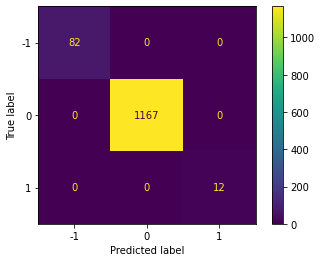

In [517]:
print('Confusion matrix:')
Y_test_pred = rf_model.predict(X_test)
cm = sklearn.metrics.confusion_matrix(Y_test, Y_test_pred)
print(cm)
plot_confusion_matrix(rf_model, X_test, Y_test) 

In [518]:
Y_test_pred = rf_model.predict(X_test)
# print(classification_report(Y_test, Y_test_pred, target_names=['sell','none','buy']))
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        82
           0       1.00      1.00      1.00      1167
           1       1.00      1.00      1.00        12

    accuracy                           1.00      1261
   macro avg       1.00      1.00      1.00      1261
weighted avg       1.00      1.00      1.00      1261



### Show results on test subset

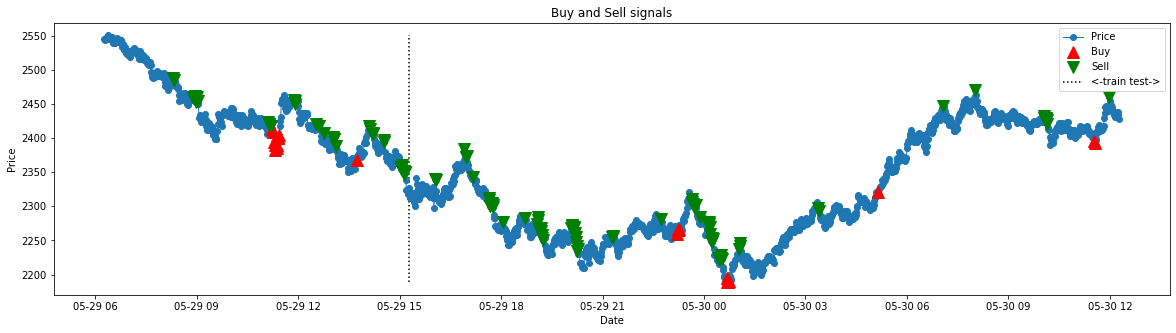

In [519]:
df9 = df8.copy()
# df9 = df9[:len(X_train)]
# df9 = df9[len(X_train):]
# print(len(df9))
# df9 = df9[1000:]

fig = plt.figure(figsize=(20, 5))
buys = df9.loc[df9["signal_predicted"] == 1]
sells = df9.loc[df9["signal_predicted"] == -1]
plt.plot(df9.index, df9['close'], lw=1., marker='o', label='Price')
plt.plot(buys.index, df9.loc[buys.index]['close'], '^', markersize=12, color='red', lw=2., label='Buy')
plt.plot(sells.index, df9.loc[sells.index]['close'], 'v', markersize=12, color='green', lw=2., label='Sell')
plt.vlines(X_test.index[0], ymin=np.min(df9['close'].values), ymax=np.max(df9['close'].values), colors='k', linestyles='dotted', label='<-train test->')
plt.ylabel('Price')
plt.xlabel('Date');
plt.title('Buy and Sell signals')
plt.legend(loc='best')
plt.show()

### Backtesting